In [2]:
import matplotlib.pyplot as plt
import numpy as np
from graspy.simulations import sbm
from numpy.random import normal, poisson
from scipy.stats import norm
import random
import itertools
from math import exp as ex
from math import log
from math import cos, sin
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
def get_edge(com1,com2,nodesPerCom,perActive):
    #get edges between two active communities with a perACtive% active edges
    activeEdge = int(perActive*nodesPerCom**2/2)
    indx = []
    
    if com1 > com2:
        com1,com2 = com2,com1
        
    node1 = range((com1-1)*nodesPerCom,com1*nodesPerCom)
    node2 = range((com2-1)*nodesPerCom,com2*nodesPerCom)
    
    for i in node1:
        for j in node2:
            if i != j:
                indx.append((i,j))
    
    indx = random.sample(indx,activeEdge)
    
    return indx

In [33]:
#Writing down the parameters for the simulation data
N = 300 #total nodes
k = 12 #community number
P = .25
dim = 3
totalSample = 150

phen1 = np.asarray([50,50,50])

#declare active communities in different classes
Phen1activeCom1 = [] #phen1 cls1
Phen1activeCom2 = [(3,5),(9,11)] #phen1 cls2
Phen1activeCom3 = [(2,4),(6,8)] #phen1 cls3

y1 = np.zeros(totalSample,dtype=int)

In [65]:
G1 = np.zeros((phen1[0],N,N))
y1 = np.zeros(phen1[0])
G2 = np.zeros((phen1[1],N,N))
y2 = np.ones(phen1[1])
G3 = np.zeros((phen1[2],N,N))
y3 = np.zeros(phen1[2])

indxG1 = []
indxG2 = []
indxG3 = []

nodesPerCom = int(N/k)
n = [nodesPerCom]*k
p = [[0.2]*k]*k
wt = [[normal]*k]*k
wtargs = []

for (i,j) in Phen1activeCom1:
    indxG1 = indxG1 + get_edge(i,i,nodesPerCom,P)
    indxG1 = indxG1 + get_edge(j,j,nodesPerCom,P)
    indxG1 = indxG1 + get_edge(i,j,nodesPerCom,P)
    
for (i,j) in Phen1activeCom2:
    indxG2 = indxG2 + get_edge(i,i,nodesPerCom,P)
    indxG2 = indxG2 + get_edge(j,j,nodesPerCom,P)
    indxG2 = indxG2 + get_edge(i,j,nodesPerCom,P)
    

for (i,j) in Phen1activeCom3:
    indxG3 = indxG3 + get_edge(i,i,nodesPerCom,P)
    indxG3 = indxG3 + get_edge(j,j,nodesPerCom,P)
    indxG3 = indxG3 + get_edge(i,j,nodesPerCom,P)

    
    
for i in range(0,k):
    wtargs.append([])
    for j in range(0,k):
        if i!=j:
            wtargs[i].append({'loc': 0.1, 'scale': 0.18})
        else:
            wtargs[i].append({'loc': 0.3, 'scale': 0.18})

for k_ in range(0,phen1[0]):
    G1[k_,:,:] = sbm(n=n, p=p, wt=wt, wtargs=wtargs)

    DiffEdge = norm.rvs(size=len(indxG1),loc=0.2,scale=0.18)
    for i in range(0,len(indxG1)):
        G1[k_,int(indxG1[i][0]),int(indxG1[i][1])] = DiffEdge[i] 
        G1[k_,int(indxG1[i][1]),int(indxG1[i][0])] = DiffEdge[i] 
            
# Creating phen1 cls2 
for k_ in range(0,phen1[1]):
    G2[k_,:,:] = sbm(n=n, p=p, wt=wt, wtargs=wtargs)
    
    DiffEdge = norm.rvs(size=len(indxG2),loc=0.2,scale=0.18)
    for i in range(0,len(indxG2)):
        G2[k_,int(indxG2[i][0]),int(indxG2[i][1])] = DiffEdge[i] 
        G2[k_,int(indxG2[i][1]),int(indxG2[i][0])] = DiffEdge[i] 
        
        
# Creating phen1 cls3
for k_ in range(0,phen1[2]):
    y3[k_] = 2
    G3[k_,:,:] = sbm(n=n, p=p, wt=wt, wtargs=wtargs)
    
    DiffEdge = norm.rvs(size=len(indxG3),loc=0.2,scale=0.18)
    for i in range(0,len(indxG3)):
        G3[k_,int(indxG3[i][0]),int(indxG3[i][1])] = DiffEdge[i] 
        G3[k_,int(indxG3[i][1]),int(indxG3[i][0])] = DiffEdge[i] 

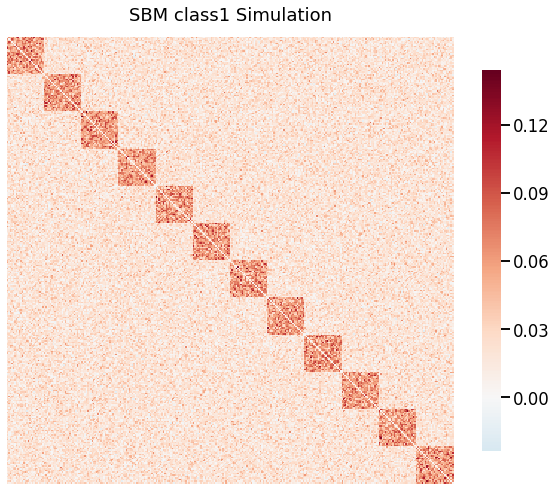

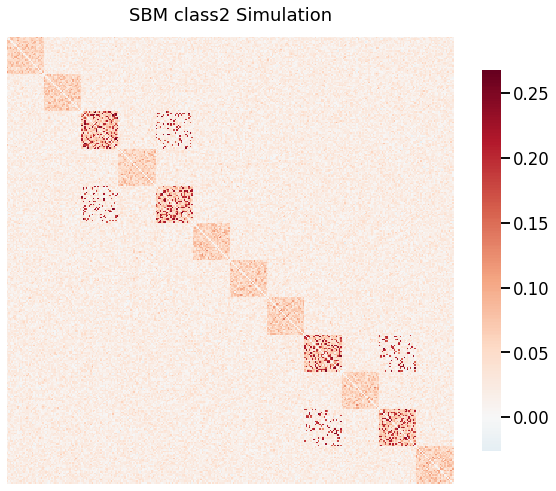

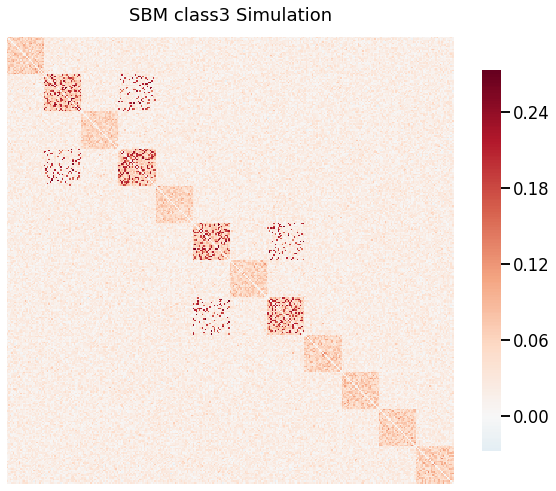

In [66]:
from graspy.plot import heatmap

heatmap(G1.mean(axis = 0), title ='SBM class1 Simulation')
heatmap(G2.mean(axis = 0), title ='SBM class2 Simulation')
heatmap(G3.mean(axis = 0), title ='SBM class3 Simulation')

In [67]:
A = np.concatenate((G1[0:40,:,:],G2[0:40,:,:],G3[0:40,:,:]), axis=0)
y1_ = np.concatenate((y1[0:40],y2[0:40],y3[0:40]), axis=0)

Atest = np.concatenate((G1[40:50,:,:],G2[40:50,:,:],G3[40:50,:,:]), axis=0)
y1test = np.concatenate((y1[40:50],y2[40:50],y3[40:50]), axis=0)

In [55]:
def fit_cls(A,e1,y1,iter,stepSize,rho,gamma):
    
    
    #we are fitting 3 parameters B,a,b to the data
    
    sampleTest,N,_ = A.shape
    dim1,_ = e1.shape
    
    B = np.ones((dim1,N,N), dtype=float)/(dim1*N*N)
    b = 0
    S = np.zeros((dim1,1), dtype=float)

    for itr in range(1,iter):
        #stepSize = stepSize/itr
        loss = 0
        gradB = np.zeros((dim1,N,N), dtype=float)
        sym = np.zeros((dim1,N,N), dtype=float)
        gradb = 0
        
        
        #update B
        for k in range(0,sampleTest):
            tmp = b
            tmpGradB = np.zeros((dim1,N,N), dtype=float) 
            
            
            
            for i in range(0,dim1):
                S[i] = np.sum(B[i,:,:]*A[k,:,:])
                
                
            for j in range(0,dim1):
                val = e1[j,:].reshape(1,-1)@S.reshape(-1,1)
                if y1[k] == j:
                    tmp -= val**2
                    for i in range(0,dim):
                        #tmp -= e1[j,i]*np.sum(B[i,:,:]*A[k,:,:]) 
                        tmpGradB[i,:,:] -= 2*val*e1[j,i]*A[k,:,:] 
                else:
                    tmp += val**2
                    for i in range(0,dim):
                        #tmp += e1[j,i]*np.sum(B[i,:,:]*A[k,:,:])
                        tmpGradB[i,:,:] += 2*val*e1[j,i]*A[k,:,:]
                        
        
            phi = ex(tmp)
            phi_ = phi/(1+phi)
            
            gradB += phi_*tmpGradB
            
        for i in range(0,dim):
            sym[i,:,:] = 2*(B[i,:,:]-B[i,:,:].T)

        gradB = gradB/sampleTest + rho*np.sign(B) + 2*gamma*B + sym
        B = B - (stepSize)*gradB
        B = B/np.linalg.norm(B)
        
        
        #update the bias b
        for k in range(0,sampleTest):
            tmp = b 
            for j in range(0,dim1):
                val = e1[j,:].reshape(1,-1)@S.reshape(-1,1)
                if y1[k] == j:
                    tmp -= val**2
                else:
                    tmp += val**2
                        
            loss += log(1+phi)
            phi = ex(tmp)
            
            gradb += phi/(1+phi)
            
        b = b - (stepSize)*gradb/sampleTest
        
    print(loss)
    
    return B,b

In [56]:
def predictAccuracy(B,b,e1,A,y1):
    l = len(y1)
    dim1,_ = e1.shape
    accuracy = 0
    S = np.zeros((dim1,1), dtype=float)
    
    for m in range(0,l):
        lbl1 = []
        for i in range(0,dim1):
                S[i] = np.sum(B[i,:,:]*A[m,:,:])
                
        for j in range(0,dim1):
            lbl1.append(e1[j,:]@S)
        
        
        
        phen1 = np.argmax(np.abs(np.asarray(lbl1)))
        
        print('The predicted labels: phenotype1=%d, true labels: phenotype1=%d'%(phen1+1,y1[m]+1))
        #print(e@R@A[i,:,:]@C,y[i])
        #print('hi')
        #print(cls, y[i])
        if phen1 == y1[m]:
            accuracy += 1

    return accuracy*100/l

In [57]:
def crossValidate(A,e1,e2,y1,y2,iter,stepSize,rho,gamma,fold):
    accuracy = np.zeros((2,1),dtype=float)
    _,count = np.unique(y, return_counts=True)
    totalSample, N, _ = A.shape
    
    count = count/totalSample
    indx = np.asarray(range(0,totalSample))
    random.shuffle(indx)
    
    testSample = int(totalSample/fold)
    for i in range(0,fold):
        indx = np.roll(indx,testSample)
        B,a,b = fit_cls(A[indx[0:totalSample-testSample],:,:],e1,e2,y1[indx[0:totalSample-testSample]],y2[indx[0:totalSample-testSample]],iter,stepSize,rho,gamma)
        testAccuracy = predictAccuracy(B,a,b,e1,e2,A[indx[totalSample-testSample:totalSample],:,:],y1[indx[totalSample-testSample:totalSample]],y2[indx[totalSample-testSample:totalSample]])
        accuracy += testAccuracy

    accuracy = accuracy/fold
    return accuracy

In [58]:
def getBase(dim):
    #create base for arbitrary dimension dim
    #here Gram-Schmidt decomposition has been used
    
    e = np.zeros((dim,dim),dtype=float)
    labelVec = np.asarray(range(1,dim+1),dtype=float)
    e[0,:] = labelVec/(labelVec@labelVec.T)**.5

    for i in range(1,dim):
        tmp = np.roll(labelVec,i)
        tmp = tmp.reshape(1,-1)
        tmp_ = tmp.copy()
        for j in range(0,i):
            eTmp = e[j,:].reshape(1,-1)
            tmp_ -= (tmp@eTmp.T/(eTmp@eTmp.T))*eTmp
            #print(tmp.shape)
        e[i,:] = tmp_/(tmp_@tmp_.T)**.5
    return e

In [ ]:
iter = 1000
stepSize = 1e-2
B = np.ones((dim,N,N), dtype=float)/(dim*N*N)
rho = 1e-3   #parameter for sparsity
gamma = 1e-6 #parameter for numerical stability
#fold = 10
#accuracy = 0

_,count1 = np.unique(y1_, return_counts=True)
dim1 = len(count1)


e1 = getBase(dim1)
totalSample, N, _ = A.shape


B,b = fit_cls(A,e1,y1_,iter,stepSize,rho,gamma)
testAccuracy = predictAccuracy(B,b,e1,Atest,y1test)    

print(testAccuracy)

#indx = np.asarray(range(0,totalSample))
#random.shuffle(indx)

#testSample = int(totalSample/fold)
#for i in range(0,fold):
#    print("Doing test on %d fold.........\n"%(i+1))
#    B,a,b = fit_cls(A[indx[0:totalSample-testSample],:,:],e1,e2,y1[indx[0:totalSample-testSample]],y2[indx[0:totalSample-testSample]],iter,stepSize,rho,gamma)
#    testAccuracy = predictAccuracy(B,a,b,e1,e2,A[indx[totalSample-testSample:totalSample],:,:],y1[indx[totalSample-testSample:totalSample]],y2[indx[totalSample-testSample:totalSample]])    
#    accuracy += testAccuracy
#    print(testAccuracy)
    
#    indx = np.roll(indx,testSample)
#accuracy = accuracy/fold
#print("Total accuracy %f %f\n"%(accuracy[0],accuracy[1]))

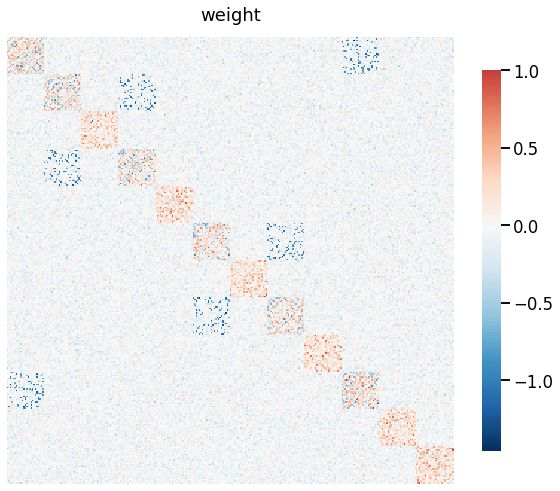

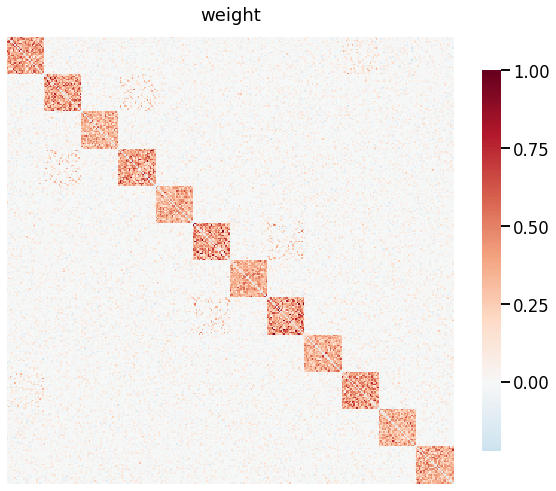

In [33]:
heatmap(B[0,:,:]/np.max(B[0,:,:]), title ='weight')
heatmap(B[1,:,:]/np.max(B[1,:,:]), title ='weight')

In [170]:
testAccuracy = predictAccuracy(B,a,b,e1,e2,A,y1_,y2_)    
print('Accuracy  on training : phen1=%f, phen2=%f'%(testAccuracy[0],testAccuracy[1]))

The predicted labels: phenotype1=1, phenotype2=1, true labels: phenotype1=2, phenotype2=2
[array([-3.0618319]), array([2.53072433])] [array([-3.06287401]), array([2.52946299])]
The predicted labels: phenotype1=1, phenotype2=1, true labels: phenotype1=2, phenotype2=2
[array([-2.72167947]), array([2.41284086])] [array([-2.72267305]), array([2.41171963])]
The predicted labels: phenotype1=1, phenotype2=1, true labels: phenotype1=2, phenotype2=2
[array([-2.71178461]), array([2.40278443])] [array([-2.71277405]), array([2.40166729])]
The predicted labels: phenotype1=1, phenotype2=1, true labels: phenotype1=2, phenotype2=2
[array([-2.90995404]), array([2.52198606])] [array([-2.91099256]), array([2.52078729])]
The predicted labels: phenotype1=1, phenotype2=1, true labels: phenotype1=2, phenotype2=2
[array([-2.54392112]), array([2.33333066])] [array([-2.54488197]), array([2.33228266])]
The predicted labels: phenotype1=1, phenotype2=1, true labels: phenotype1=2, phenotype2=2
[array([-2.9499635]),

In [181]:
a

array([[ 0.99174446, -0.12822998],
       [ 0.12822998,  0.99174446]])

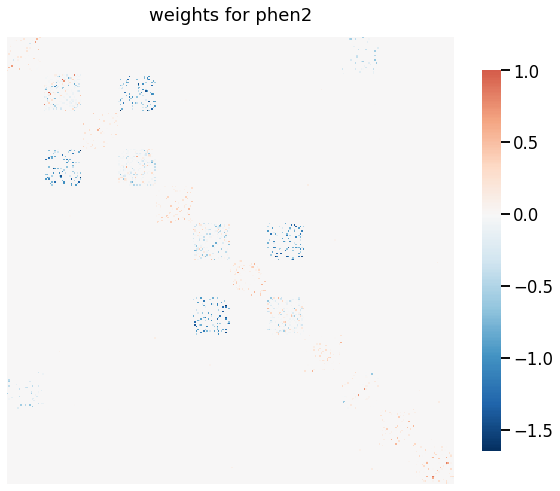

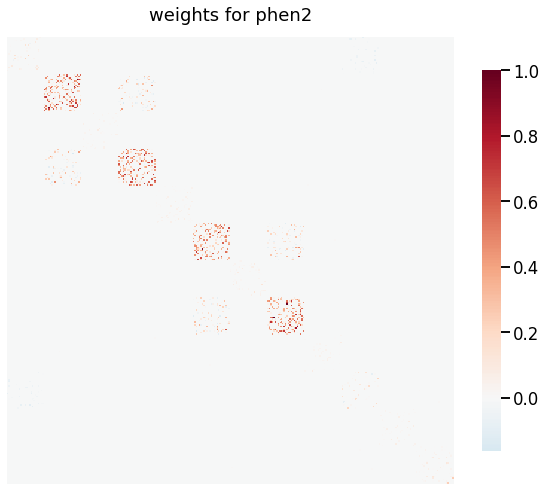

In [178]:
B1 = a[0,0]*B[0,:,:] + a[0,1]*B[1,:,:]
B2 = a[1,0]*B[0,:,:] + a[1,1]*B[1,:,:]
heatmap(B1/np.max(B1), title ='weights for phen2')
heatmap(B2/np.max(B2), title ='weights for phen2')

In [24]:
def paramPoint(A,B):
    dim,_,_ = B.shape
    pt = np.zeros((dim,1),dtype=float)
    
    for i in range(0,dim):
        pt[i] = np.sum(B[i,:,:]*A) 
        
    return pt

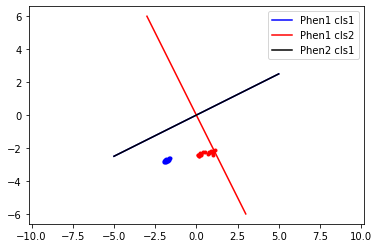

In [26]:
origin = [0], [0] # origin point
x1 = np.linspace(-5,5,1000)
x2 = np.linspace(-3,3,1000)

#plt.quiver(*origin, 300*e1[:,0], 300*e1[:,1], scale=400)
#plt.quiver(*origin, -300*e1[:,0], -300*e1[:,1], scale=400)

slope1 = e1[0][0]/e1[0][1]
slope2 = e1[1][0]/e1[1][1]

#print(slope1,slope2)
plt.plot(x1,slope1*x1,color='b',label='Phen1 cls1')
plt.plot(x2,slope2*x2,color='r',label='Phen1 cls2')


#print(slope1,slope2)
plt.plot(x1,slope1*x1,color='k',label='Phen2 cls1')


#plt.plot(x1/3,e[0][1]*(x1/3)/e[0][0],color='k')
#plt.plot(x2,e[1][1]*(x2)/e[1][0],color='k')
l = len(y1test)

for i in range(0,l):
    pt = paramPoint(Atest[i,:,:],B)
    if y1test[i] == 0:
        plt.plot(pt[1],pt[0],'.',color = 'b')
    else:
        plt.plot(pt[1],pt[0],'.',color = 'r')

        
plt.axis('equal')
plt.legend()
plt.show()

In [20]:
testAccuracy = predictAccuracy(B,b,e1,Atest,y1test)  

The predicted labels: phenotype1=2, true labels: phenotype1=2
The predicted labels: phenotype1=2, true labels: phenotype1=2
The predicted labels: phenotype1=2, true labels: phenotype1=2
The predicted labels: phenotype1=2, true labels: phenotype1=2
The predicted labels: phenotype1=2, true labels: phenotype1=2
The predicted labels: phenotype1=2, true labels: phenotype1=2
The predicted labels: phenotype1=2, true labels: phenotype1=2
The predicted labels: phenotype1=2, true labels: phenotype1=2
The predicted labels: phenotype1=2, true labels: phenotype1=2
The predicted labels: phenotype1=2, true labels: phenotype1=2
The predicted labels: phenotype1=2, true labels: phenotype1=2
The predicted labels: phenotype1=2, true labels: phenotype1=2
The predicted labels: phenotype1=2, true labels: phenotype1=2
The predicted labels: phenotype1=2, true labels: phenotype1=2
The predicted labels: phenotype1=2, true labels: phenotype1=2
The predicted labels: phenotype1=2, true labels: phenotype1=2
The pred